In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec
import csv 
# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import scipy
from defs import lon180



In [2]:
folder = ''

In [3]:
#Code for extracting proxy and pre-industrial data adapted from Oldeman et al. (2021), https://doi.org/10.5281/zenodo.5718483, 2021
#Last access: 24-01-2022

In [4]:
## ERSSTv5 data, 2x2 degree
## Huang et al., 2017, 1870-1899 SST data (pre-processed into one dataset, each year is downloaded separately)
## Downloaded 1870-1899 files compressed into one: see Processing/pre-processing/ERSSTv5.ipynb
## https://www.ncei.noaa.gov/products/extended-reconstructed-sst

file = folder+'/ERSSTv5.nc'
ds   = xr.open_dataset(file)
ds = lon180(ds) #Convert longitude to [-180,180]
ersst = ds.sst[:,0].mean(dim='time')

In [5]:
# PRISM4
# Foley & Dowsett 2019, 30k SST dataset
# https://doi.org/10.5066/P9YP3DTV
# last access: 24-01-2022
file = folder + 'cs_mp_sst_data_30k.txt'

with open(file, encoding='windows-1252') as f:
    lat = [column[1] for column in csv.reader(f,delimiter='\t')]
with open(file, encoding='windows-1252') as f:
    lon = [column[2] for column in csv.reader(f,delimiter='\t')]
with open(file, encoding='windows-1252') as f:
    prism = [column[3] for column in csv.reader(f,delimiter='\t')]
    
#skip first line + last two (empty)
PRISM_lat = np.zeros(len(lat)-3) 
PRISM_lon = np.zeros(len(lat)-3)    
PRISM_sst = np.zeros(len(lat)-3)    

for i in range(1,len(lat)-2):
    PRISM_lat[i-1] = float(lat[i])
    PRISM_lon[i-1] = float(lon[i])
    PRISM_sst[i-1] = float(prism[i])

a = np.array([PRISM_lon, PRISM_lat, PRISM_sst])
a = a[:,a[0,:]>-70]
a = a[:,a[0,:]<30]
a = a[:,a[1,:]>37]
a = a[:,a[1,:]<69]
PRISM_NA = a[:,1:] #Remove site in Mediterranean

#PI SST values at NA locations
ersst_PRISM = np.zeros(PRISM_NA.shape[1]);

for i in range(PRISM_NA.shape[1]):
    ersst_PRISM[i] = ersst.sel(lon = PRISM_NA[0,i], method='nearest').sel(lat = PRISM_NA[1,i], method='nearest')

In [6]:
# 'MC' proxy reconstructions
# McClymont et al 2020 dataset, PlioVAR, both UK37 with BAYSLINE calib, and Mg/Ca reconstr
# https://doi.pangaea.de/10.1594/PANGAEA.911847
# last access 24-01-2022

file = folder + 'PlioVAR-KM5c_T.tab'

with open(file, encoding='windows-1252') as f:
    ds = [column for column in csv.reader(f,delimiter='\t')]

Nstart = 99; Nend   = len(ds);
iLat   = 2; iLon   = 3; iUk    = 6; iMg    = 7;

MC_lat = np.zeros(Nend-Nstart)
MC_lon = np.zeros(Nend-Nstart)
MC_Uk  = np.zeros(Nend-Nstart)
MC_Mg  = np.zeros(Nend-Nstart)

for i in range(Nstart, Nend):
    MC_lat[i-Nstart] = ds[i][iLat]
    MC_lon[i-Nstart] = ds[i][iLon]
    if ds[i][iUk]=='': MC_Uk[i-Nstart] = np.nan;
    else: MC_Uk[i-Nstart] = ds[i][iUk]
    if ds[i][iMg]=='': MC_Mg[i-Nstart] = np.nan
    else: MC_Mg[i-Nstart] = ds[i][iMg]

# select only North Atlantic data
a = np.array([MC_lon, MC_lat, MC_Uk, MC_Mg])
a = a[:,a[0,:]>-80]
a = a[:,a[0,:]<10]
a = a[:,a[1,:]>30]
MC_NA = np.delete(a,6, axis=1) #remove site Mediterranean

#PI SST values at NA locations
ersst_MC = np.zeros(MC_NA.shape[1]);
deg = 1

for i in range(MC_NA.shape[1]):
    ersst_MC[i] = ersst.sel(lon = MC_NA[0,i], method='nearest').sel(lat = MC_NA[1,i], method='nearest')

In [7]:
folder = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/'
modellist =   ['GISS2.1G','EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F']#,'HadGEM3']

In [8]:
dstest = lon180(xr.open_dataset(folder+modellist[0]+'/E280/SST_annual_100yr.nc'))
lat = dstest.lat; lon = dstest.lon

dsE280 = xr.Dataset(data_vars = dict(sst=(["model", "lat", "lon"], np.zeros([len(modellist),len(lat), len(lon)]))), coords = dict(model = modellist, lat = lat, lon = lon))
dsEoi400 = xr.Dataset(data_vars = dict(sst=(["model", "lat", "lon"], np.zeros([len(modellist),len(lat), len(lon)]))), coords = dict(model = modellist, lat = lat, lon = lon))

for i in range(len(modellist)):
    model = modellist[i]
    
    ds1 = lon180(xr.open_dataset(folder+model+'/E280/SST_annual_100yr.nc'))
    dsE280.sst[i] = ds1.sst.mean(dim='time')
    
    ds2 = lon180(xr.open_dataset(folder+model+'/Eoi400/SST_annual_100yr.nc'))
    dsEoi400.sst[i] = ds2.sst.mean(dim='time')
    
sstE280 = dsE280.sst.where(dsE280.sst.count(dim='model')>10)
sstEoi400 = dsEoi400.sst.where(dsEoi400.sst.count(dim='model')>10)

mmmE280 = sstE280.where(dsE280.sst.count(dim='model')>10).mean(dim='model') #Only show MMM SST where more than 10 models indicate ocean grid cells
mmmEoi400 = sstEoi400.where(dsEoi400.sst.count(dim='model')>10).mean(dim='model')

#Uncomment lines below to save all 100-year mean SST fields into one file
#xr.DataArray.to_netcdf(sstE280, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sstE280.nc')
#xr.DataArray.to_netcdf(sstEoi400, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/sstEoi400.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [


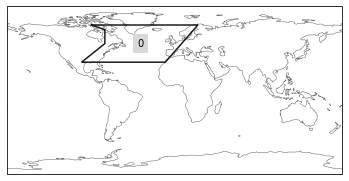

In [9]:
#Create Atlantic mask to exclude points in Mediterranean and Hudson Bay
import regionmask
model = 'EC-Earth3-LR'
Atlantic = np.array([[-100,30],[-75,50],[-75, 65],[-90,70], [25,70],[-10,30]])
region = regionmask.Regions([Atlantic])

ax = region.plot()
ax.set_extent([0, 350, -90, 90], crs=ccrs.PlateCarree())

# define lat/ lon grid
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

mask_Atl = region.mask(ds.lon.values, ds.lat.values)

In [10]:
#Latitudinal weights for SST averaging
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

#Compute NA average warming and make Atlantic anomaly fields
mmmEoi400_a = mmmEoi400-mmmEoi400.where(mask_Atl>-1).weighted(weights).mean()
mmmE280_a = mmmE280-mmmE280.where(mask_Atl>-1).weighted(weights).mean()

NA_average = mmmEoi400.where(mask_Atl>-1).weighted(weights).mean()-mmmE280.where(mask_Atl>-1).weighted(weights).mean()
NA = NA_average.values

In [11]:
#Compute SSTs at proxy locations for all models invididually
modellist =   ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

dstest = lon180(xr.open_dataset(folder+modellist[0]+'/E280/SST_annual_100yr.nc'))
lat = dstest.lat; lon = dstest.lon

dsE280 = xr.Dataset(data_vars = dict(sst=(["model", "lat", "lon"], np.zeros([len(modellist),len(lat), len(lon)]))), coords = dict(model = modellist, lat = lat, lon = lon))
dsEoi400 = xr.Dataset(data_vars = dict(sst=(["model", "lat", "lon"], np.zeros([len(modellist),len(lat), len(lon)]))), coords = dict(model = modellist, lat = lat, lon = lon))

for i in range(len(modellist)):
    model = modellist[i]
    
    ds1 = lon180(xr.open_dataset(folder+model+'/E280/SST_annual_100yr.nc'))
    dsE280.sst[i] = ds1.sst.mean(dim='time')
    
    ds2 = lon180(xr.open_dataset(folder+model+'/Eoi400/SST_annual_100yr.nc'))
    dsEoi400.sst[i] = ds2.sst.mean(dim='time')
    
sstE280 = dsE280.sst
sstEoi400 = dsEoi400.sst

modelsE280_MC = np.zeros([len(modellist),MC_NA.shape[1]]);
modelsEoi400_MC = np.zeros([len(modellist),MC_NA.shape[1]]);

deg = 1

for i in range(len(modellist)):
    for j in range(MC_NA.shape[1]):
        modelsE280_MC[i,j] = sstE280[i].sel(lon = MC_NA[0,j], method='nearest').sel(lat = MC_NA[1,j], method='nearest')
        modelsEoi400_MC[i,j] = sstEoi400[i].sel(lon = MC_NA[0,j], method='nearest').sel(lat = MC_NA[1,j], method='nearest')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.

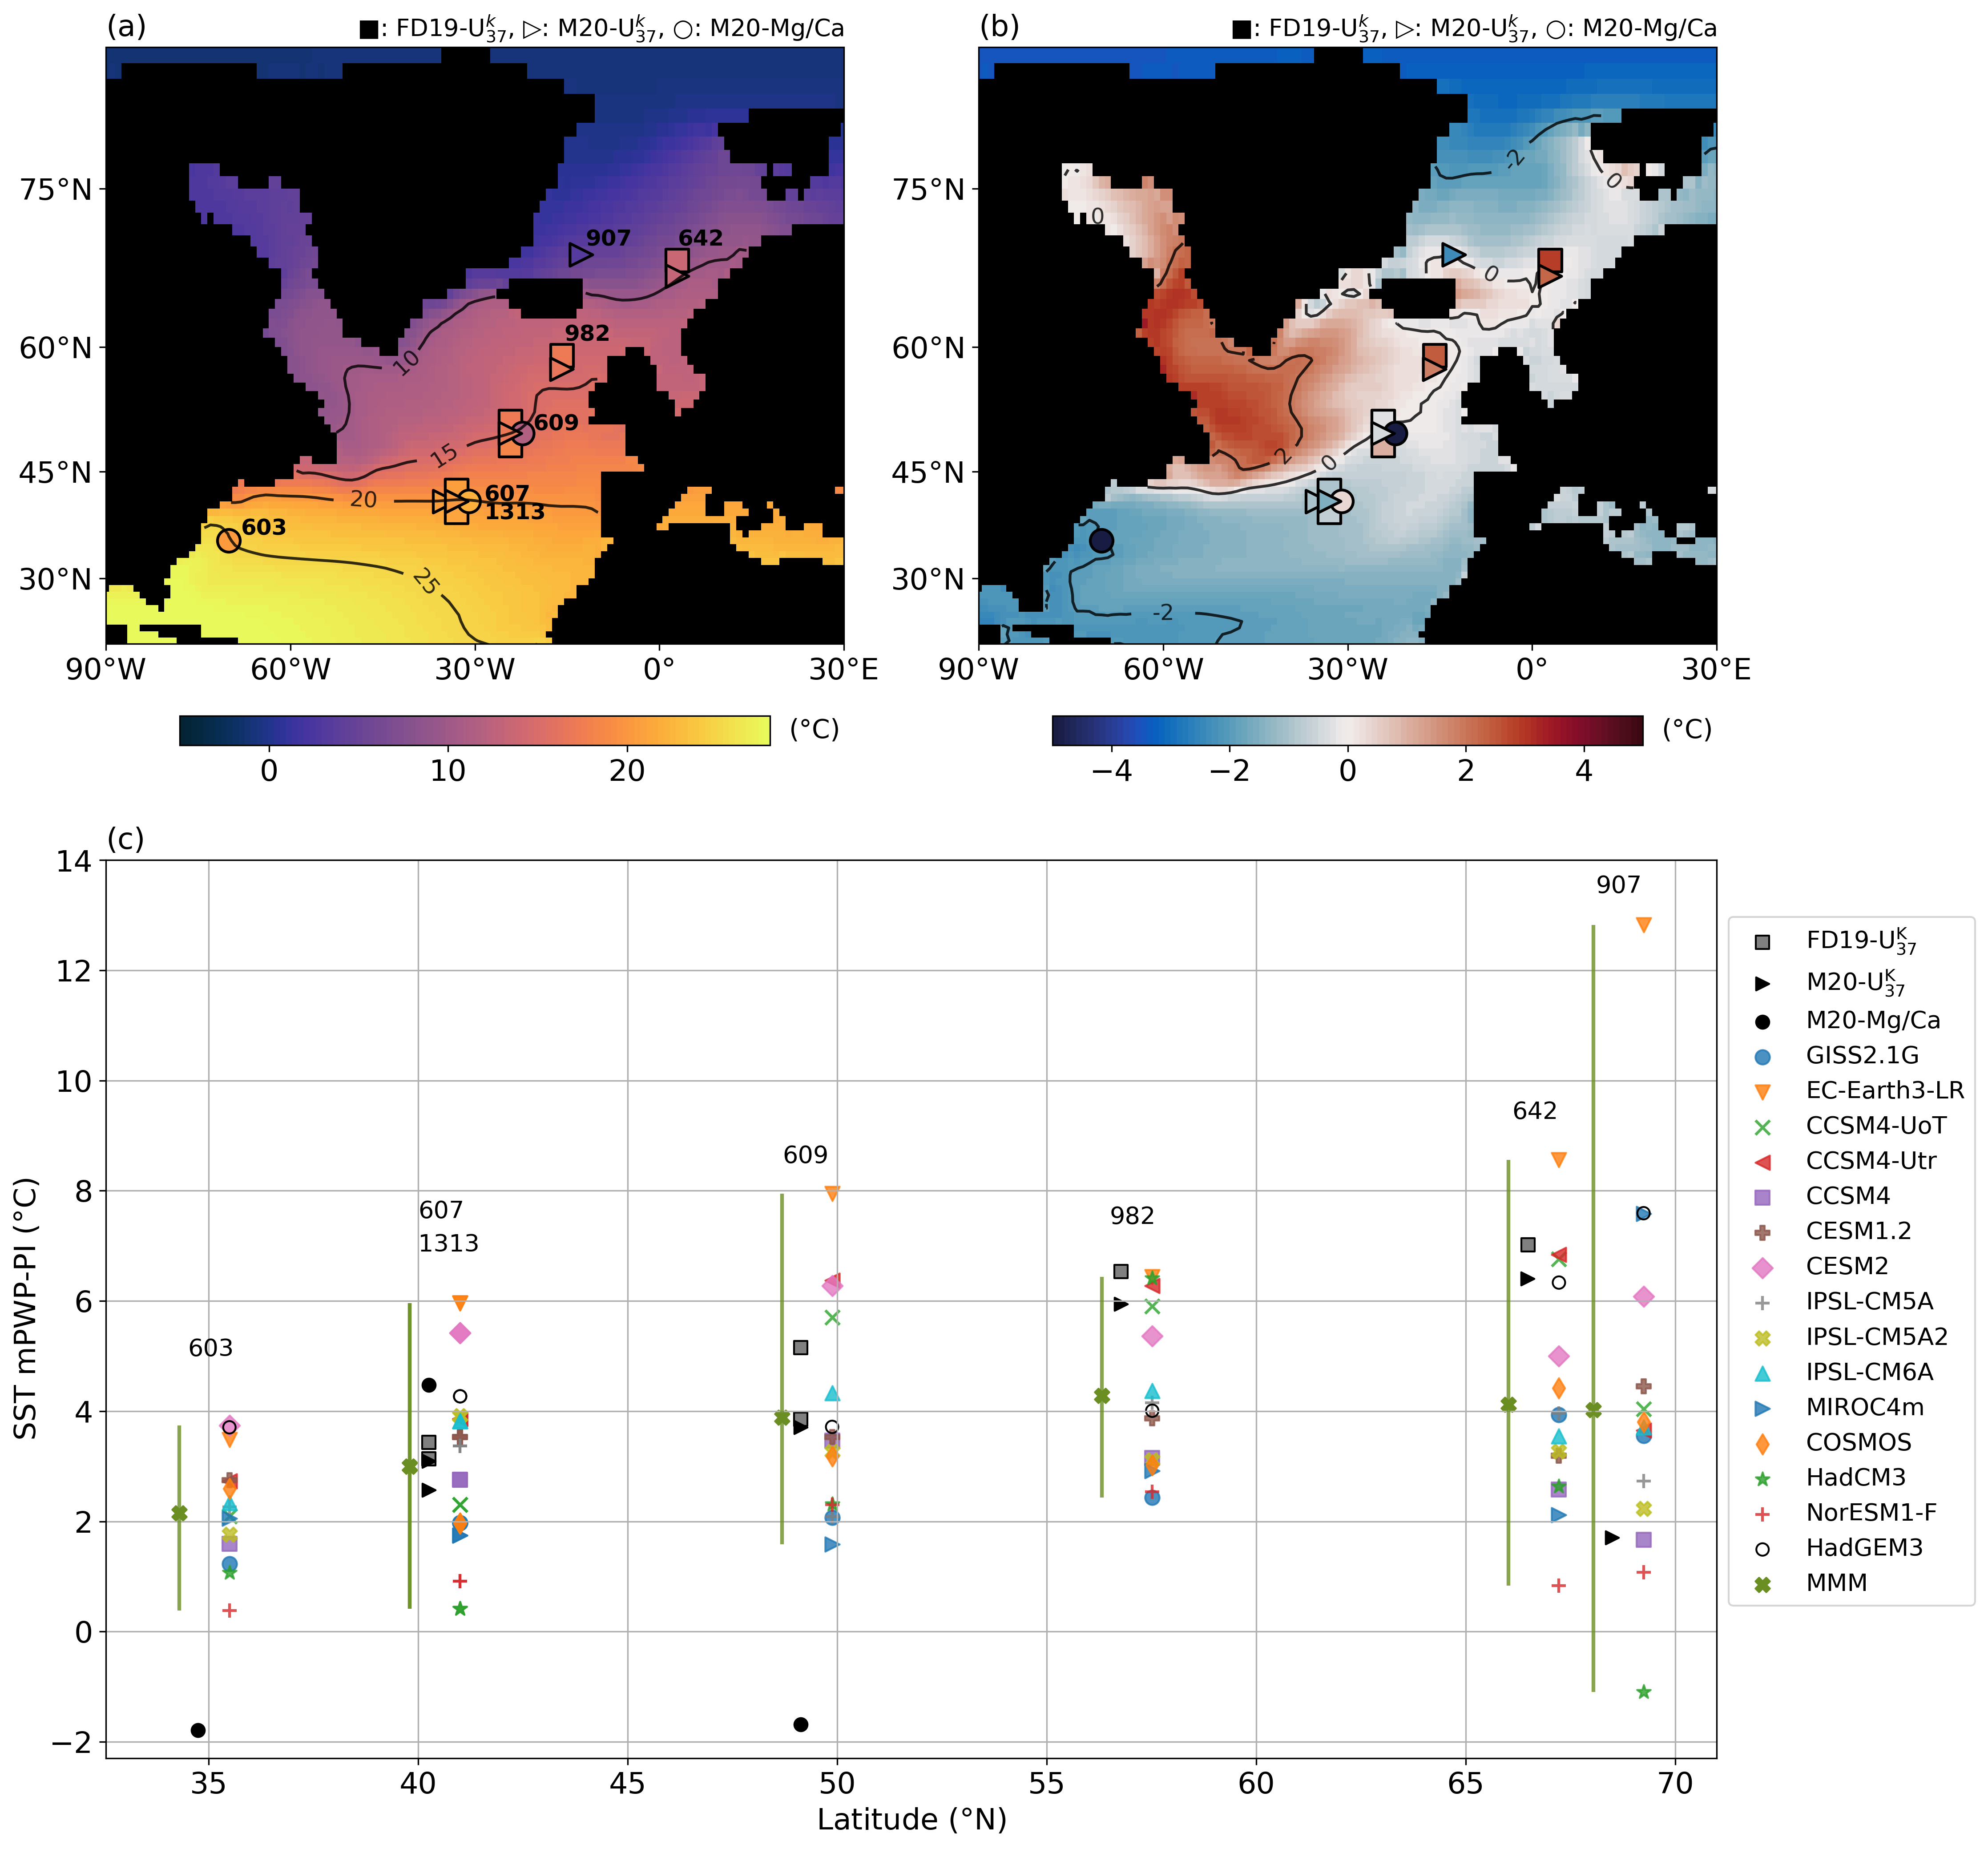

In [12]:

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize'] = 16

fig = plt.figure(figsize=(15,15),dpi=300)
spec = fig.add_gridspec(2, 2)

cmap1 = plt.get_cmap('cmo.thermal', 100)
cmap1.set_under('black')

cmap2 = plt.get_cmap('cmo.balance', 100)
cmap2.set_under('black')

ax0 = fig.add_subplot(spec[0, 0:1], projection=ccrs.Miller())

im = ax0.pcolormesh(dsE280.lon, dsE280.lat, (mmmEoi400).fillna(-1000), transform = ccrs.PlateCarree(), cmap=cmap1, shading='auto', vmin = -5, vmax = 28)

ax0.scatter(PRISM_NA[0], PRISM_NA[1]+1.5, transform = ccrs.PlateCarree(), marker='s', s=150, edgecolors='k', linewidth=1.5,
           c=(PRISM_NA[2]), cmap='cmo.thermal', vmin = -5, vmax = 28) 

ax0.scatter(PRISM_NA[0,:2], PRISM_NA[1,:2]-1.5, transform = ccrs.PlateCarree(), marker='s', s=150, edgecolors='k', linewidth=1.5,
           c=(PRISM_NA[2,:2]), cmap='cmo.thermal', vmin = -5, vmax = 28) 

ax0.scatter(MC_NA[0,3:5]+2, MC_NA[1,3:5], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[3,3:5]), cmap='cmo.thermal', vmin = -5, vmax = 28)  
ax0.scatter(MC_NA[0,-1], MC_NA[1,-1], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[3,-1]), cmap='cmo.thermal', vmin = -5, vmax = 28)  

ax0.scatter(MC_NA[0,4]-2, MC_NA[1,4], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[2,4]), cmap='cmo.thermal', vmin = -5, vmax = 28) 
ax0.scatter(MC_NA[0,:-1], MC_NA[1,:-1], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[2,:-1]), cmap='cmo.thermal', vmin = -5, vmax = 28)  

cp = ax0.contour(dsE280.lon, dsE280.lat, (mmmEoi400), transform = ccrs.PlateCarree(), colors=['k','k','k'], levels=[10,15, 20,25], alpha=0.8, zorder=1)    

manual_locations = [(-41, 66), (-35,51), (-48,43.25), (-39, 29.83)] #Locations for contour labels
ax0.clabel(cp, inline=True, fmt = '%.0f', inline_spacing=-10, fontsize=12, manual=manual_locations)
    
ax0.set_title(r'$\blacksquare$: FD19-U$^{k}_{37}$, $\triangleright$: M20-U$^{k}_{37}$, $\bigcirc$: M20-Mg/Ca', fontsize=13,loc='right')
ax0.set_extent([-90, 30, 20, 85], ccrs.PlateCarree())
ax0.set_title('(a)', loc='left', fontsize=16)
#ax[0].set_title(r'$\triangleright$: UK37 - ERSSTv5, $\bigcirc$: Mg/Ca - ERSSTv5', loc='right')
fig.colorbar(im, ax = ax0, location = 'bottom', fraction = 0.1, shrink=0.8, pad=0.08)
ax0.text(21, 5, '($\degree$C)', fontsize=14)

ax1 = fig.add_subplot(spec[0, 1:], projection=ccrs.Miller())
im = ax1.pcolormesh(dsE280.lon, dsE280.lat, (mmmEoi400_a-mmmE280_a).fillna(-1000), transform = ccrs.PlateCarree(), cmap=cmap2, shading='auto', vmin = -5, vmax = 5)
cp = ax1.contour(dsE280.lon, dsE280.lat, (mmmEoi400_a-mmmE280_a), transform = ccrs.PlateCarree(), colors=['k','k','k','k'], levels=[-2,0,2,4], alpha=0.8, zorder=1)

manual_locations = [(-60,25), (-3,99), (12.4,95), (-7,80), (-30,48),(-69,90),(-42,52)] #Locations for contour labels
ax1.clabel(cp, inline=True, inline_spacing=-2, fmt = '%.0f',  fontsize=12, manual=manual_locations)

ax1.set_extent([-90, 30, 20, 85], ccrs.PlateCarree())

ax1.scatter(PRISM_NA[0], PRISM_NA[1]+1.5, transform = ccrs.PlateCarree(), marker='s', s=150, edgecolors='k', linewidth=1.5,
           c=(PRISM_NA[2]-ersst_PRISM-NA), cmap='cmo.balance', vmin = -5, vmax = 5) 

ax1.scatter(PRISM_NA[0,:2], PRISM_NA[1,:2]-1.5, transform = ccrs.PlateCarree(), marker='s', s=150, edgecolors='k', linewidth=1.5,
           c=(PRISM_NA[2,:2]-ersst_PRISM[:2]-NA), cmap='cmo.balance', vmin = -5, vmax = 5) 

ax1.scatter(MC_NA[0,3:5]+2, MC_NA[1,3:5], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[3,3:5]-ersst_MC[3:5]-NA), cmap='cmo.balance', vmin = -5, vmax = 5)  
ax1.scatter(MC_NA[0,-1], MC_NA[1,-1], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[3,-1]-ersst_MC[-1]-NA), cmap='cmo.balance', vmin = -5, vmax = 5)  

ax1.scatter(MC_NA[0,4]-2, MC_NA[1,4], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[2,4]-ersst_MC[4]-NA), cmap='cmo.balance', vmin = -5, vmax = 5) 
ax1.scatter(MC_NA[0,:-1], MC_NA[1,:-1], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_NA[2,:-1]-ersst_MC[:-1]-NA), cmap='cmo.balance', vmin = -5, vmax = 5)  

ax1.set_title(r'$\blacksquare$: FD19-U$^{k}_{37}$, $\triangleright$: M20-U$^{k}_{37}$, $\bigcirc$: M20-Mg/Ca', fontsize=13,loc='right')
ax1.set_title('(b)', loc='left', fontsize=16)
#ax[1].set_title(r'$\triangleright$: UK37 - ERSSTv5, $\bigcirc$: Mg/Ca - ERSSTv5', loc='right')

for ax in [ax0,ax1]:
    # Longitude labels
    ax.set_xticks(np.arange(-90,31,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    ax.set_yticks(np.arange(30,80,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.colorbar(im, ax = ax1, location = 'bottom', fraction = 0.1, shrink=0.8, pad=0.08)
ax1.text(21, 5, '($\degree$C)', fontsize=14)

ax0.text(-68, 38, '603', fontsize=12, fontweight='bold')
ax0.text(-28.5, 43.5, '607', fontsize=12, fontweight='bold')
ax0.text(-28.5, 40.5, '1313', fontsize=12, fontweight='bold')
ax0.text(-20.5, 55, '609', fontsize=12, fontweight='bold')
ax0.text(-15.5, 69.5, '982', fontsize=12, fontweight='bold')
ax0.text(3, 85, '642', fontsize=12, fontweight='bold')
ax0.text(-12, 85, '907', fontsize=12, fontweight='bold')

ax3 = fig.add_subplot(spec[1, 0:])
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
   
for j in range(0,7):
    ax3.vlines(MC_NA[1,j]-1.2, np.min(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), np.max(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), color='olivedrab',zorder=2, alpha=0.8, linewidth=2)
    
ax3.scatter(PRISM_NA[1]-0.75, PRISM_NA[2]-ersst_PRISM, color='grey', s=50, marker = 's', edgecolor='k', label='FD19-U$\mathregular{^{K}_{37}}$')
ax3.scatter(MC_NA[1,:-1]-0.75, MC_NA[2,:-1]-ersst_MC[:-1], color='k',marker = '>', s=50, label='M20-U$\mathregular{^{K}_{37}}$')
ax3.scatter(MC_NA[1,3:5]-0.75, MC_NA[3,3:5]-ersst_MC[3:5], color='k',marker = 'o', s=50, label='M20-Mg/Ca')
ax3.scatter(MC_NA[1,-1]-0.75, MC_NA[3,-1]-ersst_MC[-1], color='k', s=50, marker = 'o')

for i in range(14):
    ax3.scatter(MC_NA[1], modelsEoi400_MC[i]-modelsE280_MC[i], s=60, marker = markers[i], label=modellist[i], alpha=0.8)
    
ax3.scatter(MC_NA[1], modelsEoi400_MC[-1]-modelsE280_MC[-1], s=45, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax3.scatter(MC_NA[1]-1.2, np.mean(modelsEoi400_MC[:-1], axis=0)-np.mean(modelsE280_MC[:-1], axis=0), s=60, color='olivedrab', marker='X', label='MMM')

#ax.legend(loc='upper left', fontsize=8)
ax3.set_xlabel('Latitude ($\degree$N)')
ax3.set_ylabel('SST mPWP-PI ($\degree$C)')
ax3.set_title('(c)', fontsize=16,loc='left')
ax3.legend(bbox_to_anchor=(1., 0.95), fontsize=13.)
ax3.grid()
ax3.set_ylim([-2.3, 14])

ax3.text(34.5, 5, '603', fontsize=13)
ax3.text(40, 6.9, '1313', fontsize=13)
ax3.text(40, 7.5, '607', fontsize=13)
ax3.text(48.7, 8.5, '609', fontsize=13)
ax3.text(56.5, 7.4, '982', fontsize=13)
ax3.text(66.1, 9.3, '642', fontsize=13)
ax3.text(68.1, 13.4, '907', fontsize=13)

fig.tight_layout()
plt.savefig('fig02.png', bbox_inches='tight')